In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
import numpy as np

from scipy import stats
from scipy.stats import poisson
from statsmodels.distributions.empirical_distribution import ECDF

import sdeint

In [2]:
import random
import time

### Barabasi-Albert Model
**Definition**: starting with a complete graph of $m_0$ nodes, at each time step $t = 1,...,N-m_0$ a new node $j = t+m_0$ is added.

It forms $m\leq m_0$ undirected edges with existing nodes with a probability proportional to their degree $\pi_{j,i} = \frac{k_i}{\sum_{l \in V_{t-1}}k_l} $.

Result is an undirected graph of $N$ nodes and $K = \frac{m_0(m_0-1)}{2} + m(N-m_0)$ edges.

In [3]:
m0 = 5 #initial number of nodes
m = 5 #5 edges added each time (preferential attachment)
N = 100
G = nx.barabasi_albert_graph(N, m) #The initialization is a graph with with m nodes and no edges.

In [4]:
N = len(G)
M = G.number_of_edges()
print('Number of nodes:', N)
print('Number of edges:', M)
print('Average degre:', 2*M/N)

Number of nodes: 100
Number of edges: 475
Average degre: 9.5


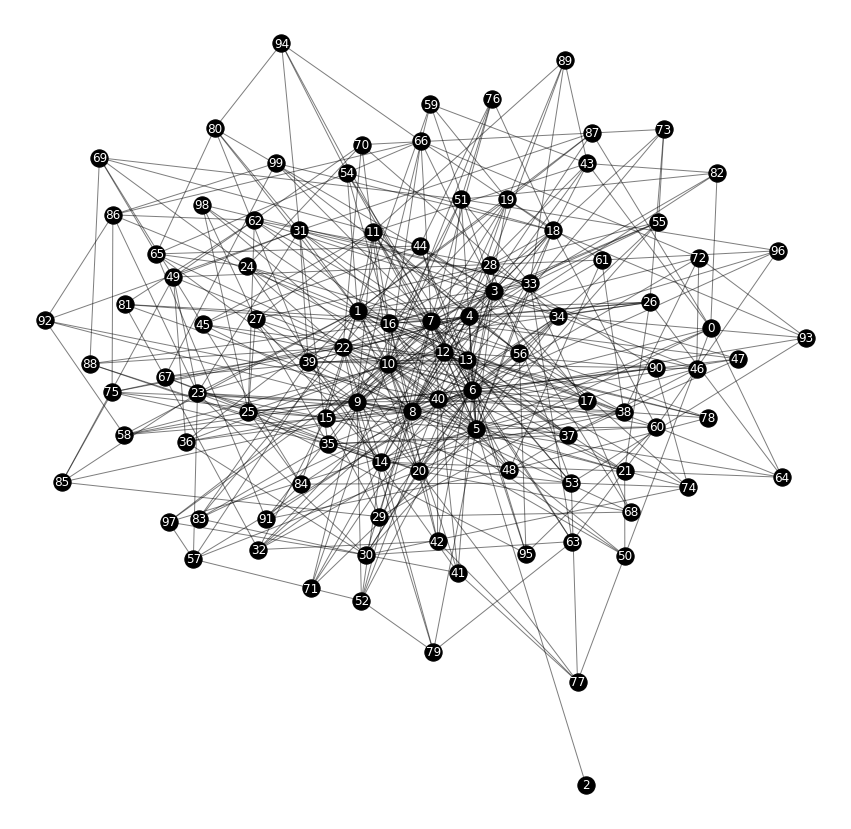

In [8]:
pos = nx.fruchterman_reingold_layout(G);
#pos = nx.circular_layout(G);
plt.figure(figsize=(15,15));
plt.axis("off");
nx.draw_networkx_nodes(G, pos, node_size=300, node_color="black");
nx.draw_networkx_edges(G, pos, alpha=0.500);
nx.draw_networkx_labels(G, pos, font_color="white");
plt.show();

In [ ]:
def degree_distribution(GER):
    vk = dict(GER.degree())
    vk = list(vk.values())
    maxk = np.max(vk)
    mink = np.min(vk)
    kvalues= np.arange(0,maxk+1) # possible values of k
    Pk = np.zeros(maxk+1) # P(k)
    for k in vk:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
    return kvalues,Pk

In [ ]:
Count_degree = list(dict(G.degree()).values())

In [ ]:
ks, Pk = degree_distribution(G)

**Degree Distribution for a single realisation** - Notice the probability of a lot of the degrees $p(k)$ are 0. For this reason we plot the tail of the degree distribution (1-CDF).

To do this we can get "exact" cdf with `np.cumsum` (not very smooth) or review `Support_Class_2.ipynb` where we calculated a histogram with the data Count_degree to get bins/approximations.

In [ ]:
plt.figure()
plt.plot(ks,Pk,'bo', label='Data')
plt.xlabel("k", fontsize=20)
plt.ylabel("P(k)", fontsize=20)
plt.title("Degree distribution", fontsize=20)
plt.grid(True)

In [ ]:
plt.figure()
cdf = np.cumsum(Pk)
x = np.linspace(np.min(Count_degree),np.max(Count_degree),10000)
plt.plot(range(len(cdf)), 1-cdf, '--', label ='One realisation, empirical tail ')
plt.plot(x, x**(-2), label = 'power law')
plt.xlabel('degree, k', fontsize = 16)
plt.title('Empirical Tail (1 realisation)', fontsize = 16)
plt.xlim([np.min(Count_degree),np.max(Count_degree)])
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize = 12)

In [ ]:
realisations = 20
m = 5
N =1000
degrees = []
for r in range(realisations):
    G= nx.barabasi_albert_graph(N,m)
    Count_degree = list(dict(G.degree()).values())
    degrees.append(Count_degree)
degrees = np.array(degrees)
degrees = degrees.flatten()

In [ ]:
ecdf_deg = ECDF(degrees)

In [ ]:
plt.figure()
# bins, deg = one_cdf(degrees)
plt.plot(ecdf_deg.x, np.ones(len(ecdf_deg.y))-ecdf_deg.y, '--', label = '20 realisations, empirical tail')
Xx = np.linspace(min(degrees), max(degrees), 1000)
plt.plot(Xx, Xx**(-2), label = 'Power law')
plt.title('Empirical Tail (20 realisations)', fontsize = 16)

plt.legend(fontsize =12)
plt.xlabel('degree, k', fontsize = 16)
plt.xscale('log')
plt.yscale('log')
plt.xlim([np.min(degrees),np.max(degrees)])
plt.ylim([1e-6, 1])

**Uncorrelated or (dis-)assortative?**

Expected degree of nearest neighbour, given node has node $k$:

$$k_{nn}(k) = \mathbb{E}\left[ \frac{\sum_{i \in V} k_{nn, i} \delta_{k_i,k}}{\sum_{i \in V} \delta_{k_i, k} } \right], \ \text{where} \ k_{nn,i} = \frac{1}{k_i} \sum_{j \in V} a_{ij}k_j$$

To find $k_{nn,i}$ we can use `nx.average_neighbor_degree(G)`

In [ ]:
m = 10
N = 1000
G = nx.barabasi_albert_graph(N, m) 

In [ ]:
def k_nn(G,kmax):
    knn = np.zeros(kmax) #be careful if you get zeros! There are undefined ( can't divide through by zero)
    Degrees = list(dict(G.degree()).values())
    Degrees = np.array(Degrees)
    knn_i = np.array(list(nx.average_neighbor_degree(G).values()))
    for k in range(kmax):
        delta_ki_k = np.equal(Degrees, k).astype(int)
        numerator = np.sum(delta_ki_k*knn_i)
        denominator = np.sum(delta_ki_k)
        if denominator !=0:
            knn[k] = numerator/denominator
    return knn

In [ ]:
realisations = 20
kmax = 200
M = np.zeros((kmax, realisations))
for i in range(realisations):
    G = nx.barabasi_albert_graph(N,m)
    knn_final = k_nn(G, kmax)
    for k in range(len(knn_final)):
        if knn_final[k] == 0:
            knn_final[k] = None #undefined values
    M[:,i] = knn_final

In [ ]:
Average = np.mean(M, axis = 1)

In [ ]:
plt.figure(figsize = (5,5))
plt.plot(range(kmax), Average, 'x')
plt.xlabel('k, Degree of node', fontsize = 16)
plt.ylabel(r'$k_{nn}(k)$ ', fontsize = 16)

# Problem sheet 3 - Contact Process

The contact process in 1D has rates to flip the state of agent i given by
$$
c(\eta ,\eta^i )=\eta (i)+\lambda\big( 1-\eta (i)\big)\big(\eta (i+1)+\eta (i-1)\big)\ .
$$
We implement a rejection-based random sequential algorithm. The local rates at i are: 1 for recovery, $\lambda$ for infection with one infected neighbour, and $2\lambda$ for two infected neighbours.

### Simulation:
- Sample a sites $i$ uniformly, independently with rate $L*rmax=2\lambda L$. 
- update site $i$ with correct probability

I tried several versions and this seems to be the fastest Python can do, with drawing a list of random variables in advance using np.random. Still this is nowhere near the speed needed to do the homework...

$\Rightarrow$ do NOT use Python for more involved MC simulations

In [ ]:
### Parameters ###

runs=10   ## of simulations for average

𝜆=1.68    #infection rate
L=128     ## of agents

tmax=10.*L     #simulation time
outs=200       ## of outputs in time
deltat=tmax/outs   #time between outputs

rates=[0.,𝜆,2*𝜆,1.]
rmax=max(rates)
pr=[x/rmax for x in rates]

wait=1./(L*rmax)

#################

N=np.zeros(outs, dtype=int)              #initialize fraction of infecteds vector

t0=time.time()

for k in range(0, runs):
    randi=np.random.randint(L, size=int((tmax+2)*L*rmax))   #generate enough random indices
    randu=np.random.random_sample(int((tmax+2)*L*rmax))       #random uniforms
    rind=0                                                    #index for rands

    𝜂=np.ones((L,), dtype=int)   #initialize current configuration
    nii=L                        ## of infecteds
    
    t=0.0
    nextout=deltat
    kout=0
    
    while (t<tmax): # loop until done 
        while (t<nextout):
#            wait=np.random.exponential(meanwait) # random holding time
            pos=randi[rind]      #select which site to try and flip
            if (𝜂[pos]==1):
                # infected case
                if (randu[rind]<pr[3]): #try flip
                    𝜂[pos]=0  # site recovers
                    nii+=-1   # decrease number of infected 
            else:
                # uninfected case 
                nin=𝜂[(pos+1)%L]+𝜂[(pos-1)%L]
                if (randu[rind]<pr[nin]):
                    𝜂[pos]=1  # site becomes infected
                    nii+=1    # increase number of infected
            rind+=1 # move to next site
            t+=wait # update lapsed time
            
        N[kout]+=nii
        kout+=1
        nextout+=deltat
    
Nnorm = [1.*x/(runs*L) for x in N]

t1=time.time()
print(t1-t0)

In [ ]:
times=np.arange(np.shape(N)[0])*deltat

In [ ]:
plt.figure(figsize = (15,8))
plt.plot(times,Nnorm,'o')

plt.xscale('log')
plt.yscale('log')
    
plt.xlabel('Time, $t$', fontsize = 20)
plt.ylabel('$N_t /L$', fontsize= 20)

plt.title("$N_t$ Number of individuals of each species \n out of total population size L = {}".format(L), fontsize = 20)

In [ ]:
data1 = np.loadtxt("contact_n512/contact_n512_l16.3.dat", delimiter=' ')
data2 = np.loadtxt("contact_n512/contact_n512_l16.4.dat", delimiter=' ')
data3 = np.loadtxt("contact_n512/contact_n512_l16.5.dat", delimiter=' ')
data4 = np.loadtxt("contact_n512/contact_n512_l16.6.dat", delimiter=' ')
data5 = np.loadtxt("contact_n512/contact_n512_l16.7.dat", delimiter=' ')
data6 = np.loadtxt("contact_n512/contact_n512_l16.8.dat", delimiter=' ')

In [ ]:
ydata1=sum([data1[k*200:(k+1)*200,0] for k in range(500)])/500/512;
ydata2=sum([data2[k*200:(k+1)*200,0] for k in range(500)])/500/512;
ydata3=sum([data3[k*200:(k+1)*200,0] for k in range(500)])/500/512;
ydata4=sum([data4[k*200:(k+1)*200,0] for k in range(500)])/500/512;
ydata5=sum([data5[k*200:(k+1)*200,0] for k in range(500)])/500/512;
ydata6=sum([data6[k*200:(k+1)*200,0] for k in range(500)])/500/512;

In [ ]:
times=data1[0:200,1];

In [ ]:
plt.figure(figsize = (15,8))
plt.plot(times,ydata1)
plt.plot(times,ydata2)
plt.plot(times,ydata3)
plt.plot(times,ydata4)
plt.plot(times,ydata5)
plt.plot(times,ydata6)


plt.xscale('log')
plt.yscale('log')
    
plt.xlabel('Time, $t$', fontsize = 20)
plt.ylabel('$N_t /L$', fontsize= 20)

#  Mean-field Contact Process

## Simulate total number of infecteds

In [ ]:
### Parameters ###

L=512     ## of agents
lah=1.1
𝜆=lah/L    #infection rate

tmax=10.     #simulation time
outs=500       ## of outputs in time
deltat=tmax/outs   #time between outputs


#################

N=np.ones(outs+1)              #initialize output vector (normalized)
state=50                                 #initialize current state 
N[0]=0.1

tt=[1./(𝜆*(L-n)*n+n) for n in (np.arange(L)+1)]
tt=np.concatenate(([0],tt))
pm=[1./(𝜆*(L-m)+1.) for m in (np.arange(L)+1)]
pm=np.concatenate(([0],pm))

t0=time.time()

t=0.0
nextout=deltat
kout=1

while (t<tmax): # loop until done 
    while (t<nextout):
        t+=tt[state]
        if (random.random()<pm[state]):
            state+=-1
        else:
            state+=+1
        if (state==0):
            t=tmax+1.
    N[kout]=(state+0.)/(L+0.)
    kout+=1
    nextout+=deltat

t1=time.time()
print(str(t1-t0)+'seconds')

In [ ]:
times=np.arange(np.shape(N)[0])*deltat

In [ ]:
plt.figure(figsize = (15,8))
plt.plot(times,N,'r')

#plt.xscale('log')
#plt.yscale('log')
    
plt.xlabel('Time, $t$', fontsize = 20)
plt.ylabel('$N_t /L$', fontsize= 20)

#plt.title("$N_t $ Number of individuals of each species \n out of total population size L = {}".format(L), fontsize = 20)

In [ ]:
def fX(x, t):
    return lah*(1-x)*x-x

def gX(x, t):
    return np.sqrt((lah*(1-x)*x+x)/L)

def gY(x, t):
    return 0.

Xt = sdeint.itoint(fX, gX, 0.1, times)
Yt = sdeint.itoint(fX, gY, 0.1, times)

In [ ]:
plt.figure(figsize = (15,8))
plt.plot(times,Xt)
plt.plot(times,N,'r')
plt.plot(times,Yt,'k')

#plt.xscale('log')
#plt.yscale('log')
    
plt.xlabel('Time, $t$', fontsize = 20)
plt.ylabel('$N_t /L$', fontsize= 20)